In [10]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import polars as pl
from sklearn.preprocessing import StandardScaler

## Data Loading

In [23]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
data = reader.read_parquet("preprocessed.parquet/data_clean_symb_1.parquet")
latent_X_train = reader.read_parquet("preprocessed.parquet/latent_X_train.parquet")
latent_X_val = reader.read_parquet("preprocessed.parquet/latent_X_val.parquet")

data = data.sort(['date_id','time_id'])
latent_X_train = latent_X_train.sort(['date_id','time_id'])
latent_X_val = latent_X_val.sort(['date_id','time_id'])

# Split and standardization

In [24]:
target = "responder_6"
features = [col for col in latent_X_train.columns if "latent" in col]

y = data.select(target) 
latent_X_train = latent_X_train.select(features)
latent_X_val = latent_X_val.select(features)

n = X.height
n_train = int(0.8 * n)
y_train_raw = y.slice(0, n_train)
y_val_raw = y.slice(n_train)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = pl.from_numpy(
    scaler_x.fit_transform(latent_X_train.to_numpy()), 
    schema=latent_X_train.schema
)
X_val = pl.from_numpy(
    scaler_x.transform(latent_X_val.to_numpy()), 
    schema=latent_X_val.schema
)

y_train = pl.from_numpy(
    scaler_y.fit_transform(y_train_raw.to_numpy()), 
    schema=y_train_raw.schema
)
y_val = pl.from_numpy(
    scaler_y.transform(y_val_raw.to_numpy()), 
    schema=y_val_raw.schema
)

In [25]:
print(f"X_train shape : {X_train.shape}")
print(f"X_val shape : {X_val.shape}")

print(f"y_train shape : {y_train.shape}")
print(f"y_val shape : {y_val.shape}")

X_train shape : (1189975, 16)
X_val shape : (297494, 16)
y_train shape : (1189975, 1)
y_val shape : (297494, 1)


# Train

  5%|▌         | 1/20 [02:37<49:55, 157.67s/it]

Epoch 001 | R² Train: 0.8156 | R² Val: 0.8488


 10%|█         | 2/20 [05:16<47:34, 158.59s/it]

Epoch 002 | R² Train: 0.8397 | R² Val: 0.8551


 15%|█▌        | 3/20 [07:55<44:57, 158.70s/it]

Epoch 003 | R² Train: 0.8463 | R² Val: 0.8566


 20%|██        | 4/20 [10:35<42:25, 159.09s/it]

Epoch 004 | R² Train: 0.8519 | R² Val: 0.8644


 25%|██▌       | 5/20 [13:14<39:45, 159.04s/it]

Epoch 005 | R² Train: 0.8564 | R² Val: 0.8677


 30%|███       | 6/20 [15:53<37:08, 159.16s/it]

Epoch 006 | R² Train: 0.8594 | R² Val: 0.8693


 35%|███▌      | 7/20 [18:33<34:29, 159.22s/it]

Epoch 007 | R² Train: 0.8614 | R² Val: 0.8665


 40%|████      | 8/20 [21:12<31:50, 159.23s/it]

Epoch 008 | R² Train: 0.8625 | R² Val: 0.8703


 45%|████▌     | 9/20 [23:51<29:11, 159.19s/it]

Epoch 009 | R² Train: 0.8636 | R² Val: 0.8711


 50%|█████     | 10/20 [26:30<26:31, 159.16s/it]

Epoch 010 | R² Train: 0.8645 | R² Val: 0.8741


 55%|█████▌    | 11/20 [29:09<23:51, 159.09s/it]

Epoch 011 | R² Train: 0.8658 | R² Val: 0.8748


 60%|██████    | 12/20 [31:48<21:13, 159.17s/it]

Epoch 012 | R² Train: 0.8662 | R² Val: 0.8748


 65%|██████▌   | 13/20 [34:27<18:34, 159.17s/it]

Epoch 013 | R² Train: 0.8664 | R² Val: 0.8749


 70%|███████   | 14/20 [37:07<15:54, 159.12s/it]

Epoch 014 | R² Train: 0.8674 | R² Val: 0.8723


 75%|███████▌  | 15/20 [39:45<13:15, 159.05s/it]

Epoch 015 | R² Train: 0.8675 | R² Val: 0.8743


 80%|████████  | 16/20 [42:25<10:36, 159.12s/it]

Epoch 016 | R² Train: 0.8680 | R² Val: 0.8751


 85%|████████▌ | 17/20 [45:04<07:57, 159.15s/it]

Epoch 017 | R² Train: 0.8686 | R² Val: 0.8711


 90%|█████████ | 18/20 [47:43<05:18, 159.08s/it]

Epoch 018 | R² Train: 0.8674 | R² Val: 0.8739


 95%|█████████▌| 19/20 [50:22<02:39, 159.11s/it]

Epoch 019 | R² Train: 0.8690 | R² Val: 0.8750


100%|██████████| 20/20 [53:01<00:00, 159.08s/it]

Epoch 020 | R² Train: 0.8689 | R² Val: 0.8758


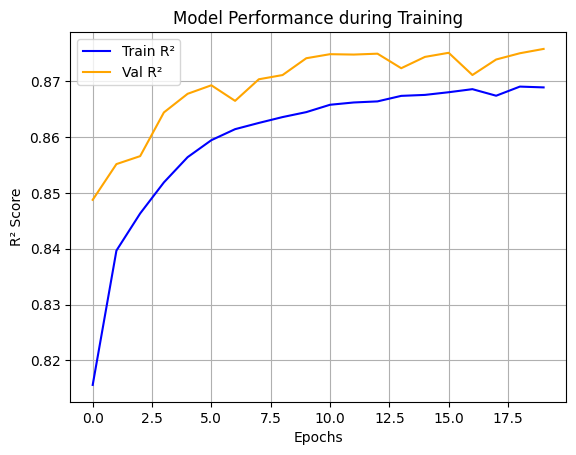

In [26]:
from models.transformers import TimeSeriesTransformer
from models.transformers_utils import train_model

n_features = X_train.shape[1]
lr = 0.5e-2
criterion = nn.MSELoss()
n_epochs = 20
batch_size = 2048
device = "cuda"
seq_len = 128
d_model = 16
num_heads = 4
num_layers = 3
d_ff = 16

model = TimeSeriesTransformer(
    n_features=n_features,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff
)

optimizer = optim.Adam(model.parameters(), lr=lr)

r2_train_hist, r2_val_hist = train_model(
    model, optimizer, criterion, 
    X_train, y_train, X_val, y_val,
    epochs=n_epochs, batch_size=batch_size, seq_len=seq_len, device=device, plot=True
)

In [27]:
import pandas as pd
scores = pd.DataFrame({
    "train":r2_train_hist,
    "val":r2_val_hist
})
scores.to_parquet("1_latent_features_tf_scores.parquet")

# Comparison

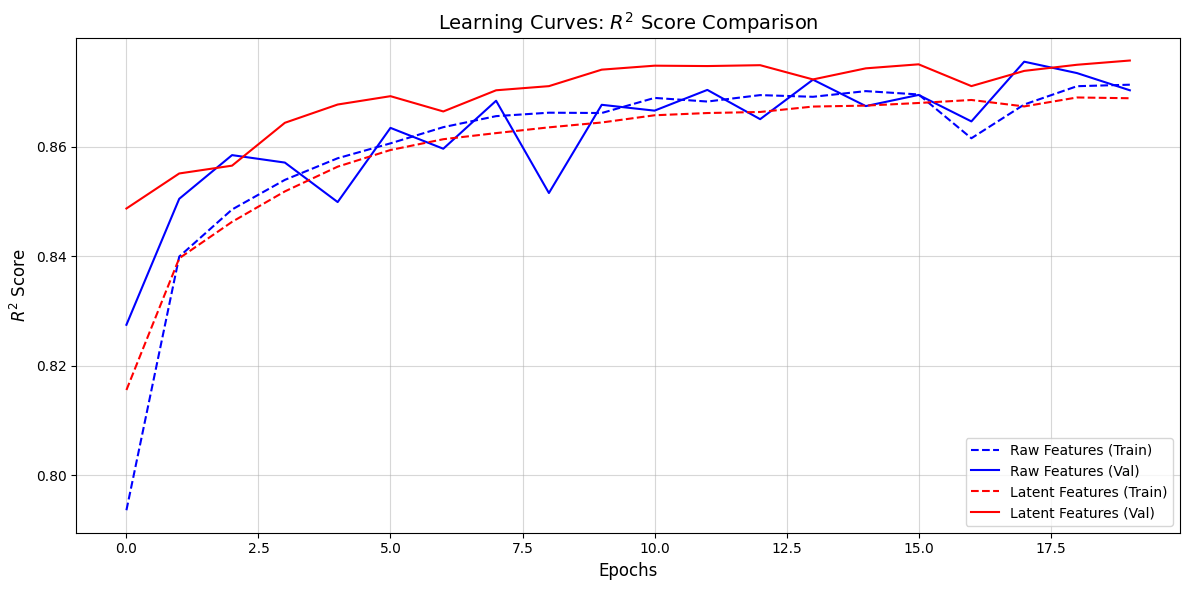

In [41]:
import matplotlib.pyplot as plt

scores_raw_features = pd.read_parquet("0_baseline_tf_scores.parquet")
scores_latent_features = pd.read_parquet("1_latent_features_tf_scores.parquet")

scores_comparison = pd.concat({
    "Raw features":scores_raw_features,
    "Latent Features":scores_latent_features
}, axis = 1)

scores_comparison.columns = ["raw_train", "raw_val", "latent_train", "latent_val"]
scores_comparison["epoch"] = scores_comparison.index.to_series()

plt.figure(figsize=(12, 6))

plt.plot(scores_comparison['epoch'], scores_comparison['raw_train'], label='Raw Features (Train)', color='blue', linestyle='--')
plt.plot(scores_comparison['epoch'], scores_comparison['raw_val'], label='Raw Features (Val)', color='blue', linestyle='-')

plt.plot(scores_comparison['epoch'], scores_comparison['latent_train'], label='Latent Features (Train)', color='red', linestyle='--')
plt.plot(scores_comparison['epoch'], scores_comparison['latent_val'], label='Latent Features (Val)', color='red', linestyle='-')

plt.title('Learning Curves: $R^2$ Score Comparison', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('$R^2$ Score', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()
